In [74]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import cmocean.cm as ocm
import pandas as pd

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data')
int_dir = os.path.join(data_dir,'analysis','interim')
pro_dir = os.path.join(data_dir,'analysis','processed')
fig_dir = os.path.join(os.pardir,os.pardir,'reports','figures')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from tools.log_progress import log_progress
from visualization.shiftedColorMap import shiftedColorMap
from tools.uvp_masks import uvp_masks
from tools.insituTemp import calc_insituTemp

In [16]:
from dask.distributed import Client
c = Client()
c

Client Scheduler: tcp://127.0.0.1:49288 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 101.38 GB


In [77]:
#grid_path = os.path.join(data_dir,'preprocessing','processed','waom2_grd.nc')
grid_path = os.path.join(data_dir,'analysis','interim','grd2_dV.nc')
u_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_u_avg.nc')
v_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_v_avg.nc')
temp_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_temp_avg.nc')
salt_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_salt_avg.nc')
m_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_m_avg.nc')
sector_masks_path = os.path.join(data_dir,'analysis','interim','mask_sector_2.npy') 
shelves_masks_path = os.path.join(data_dir,'analysis','interim','shelves2.npy') 

grd = xr.open_dataset(grid_path)
u = xr.open_mfdataset(u_path,chunks={'xi_u':200,'eta_u':200}).u.squeeze()
v = xr.open_mfdataset(v_path,chunks={'xi_v':200,'eta_v':200}).v.squeeze()
temp = xr.open_mfdataset(temp_path,chunks={'xi_rho':200,'eta_rho':200}).temp.squeeze()
salt = xr.open_mfdataset(salt_path,chunks={'xi_rho':200,'eta_rho':200}).salt.squeeze()
m = xr.open_dataset(m_path).m.squeeze()
sector = np.load(sector_masks_path).item()
shelves = np.load(shelves_masks_path).item()

In [80]:
shelves = {k: v for k, v in shelves.items() if v['mask'].any() and k in ['Filchner','Abbot','Amery']}

In [81]:
from scipy.ndimage.morphology import binary_dilation as bd
def make_front_mask(shelf_mask):
    mask_bd = bd(shelf_mask,iterations=10)
    mask_fr = (mask_bd) & (~shelf_mask) & (grd.mask_rho==1) & (grd.zice==0)    
    return mask_fr

for key,data in log_progress(shelves.items(),every=2):
    shelves[key]['mask_front'] = make_front_mask(data['mask'])

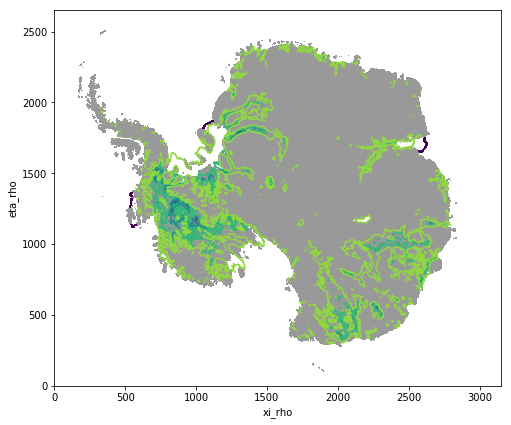

In [8]:
plt.close()
fig,ax = plt.subplots(figsize=(8,10))
ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))
grd.zice.plot.contourf(ax=ax,add_colorbar=False)
for key,data in log_progress(shelves.items(),every=2):
    grd.mask_rho.where(data['mask_front']).plot(ax=ax,add_colorbar=False)
ax.set_aspect('equal')
plt.show()

In [141]:
def dTemp(Sal,Temp,Pres):
    '''Calculates from the salinity (Sal,psu), the in-situ Temperature
       (Temp, degC) and the in-situ pressure (Pres, dbar) the adiabatic 
       temperature gradient (dTemp, K Dbar^-1).

         Check values:  dTemp  =     3.255976E-4 K dbar^-1
                  given Sal    =    40.0         psu
                        Temp   =    40.0         degC
                        Pres   = 10000.000       dbar
    ''' 
    s0=35.0
    a0,a1,a2,a3 = (3.5803e-5, 8.5258e-6, -6.8360e-8, 6.6228e-10)
    b0,b1 = (1.8932e-6, -4.2393e-8)
    c0,c1,c2,c3 = (1.8741e-8, -6.7795e-10, 8.7330e-12, -5.4481e-14)
    d0,d1  = (-1.1351e-10, 2.7759e-12)
    e0,e1,e2 = (-4.6206e-13,  1.8676e-14, -2.1687e-16)
    ds = Sal-s0

    dTemp = (((e2*Temp + e1)*Temp + e0 )*Pres + \
            ((d1*Temp + d0)*ds + ((c3*Temp + c2)*Temp + c1 )*Temp + c0 ) )*Pres + \
            (b1*Temp + b0)*ds +  ((a3*Temp + a2)*Temp + a1 )*Temp + a0

    return dTemp


def thetaa(Sal,Temp,Pres,RPres):
    '''! Calculates from the salinity (sal, psu), the in-situ temperature 
    ! (Temp, degC) and the in-situ pressure press, dbar) the potential 
    ! temperature (Theta, degC) converted to the reference pressure
    ! (RPres, dbar). A Runge-Kutta procedure of the fourth order is used.
    !
    ! Check value: theta   =    36.89073  degC
    !         given sal    =    40.0      psu
    !               Temp   =    40.0      degC
    !               pres   = 10000.000    dbar
    !               rfpres =     0.000    dbar'''

    ct2,ct3 =  (0.29289322 ,  1.707106781)
    cq2a,cq2b = (0.58578644 ,  0.121320344)
    cq3a,cq3b = (3.414213562, -4.121320344)
    p  = Pres
    t  = Temp
    dp = RPres-Pres
    dt = dp*dTemp(Sal,t,p)
    t  = t +0.5*dt
    q = dt
    p  = p +0.5*dp
    dt = dp*dTemp(Sal,t,p)
    t  = t + ct2*(dt-q)
    q  = cq2a*dt + cq2b*q
    dt = dp*dTemp(Sal,t,p)
    t  = t + ct3*(dt-q)
    q  = cq3a*dt + cq3b*q
    p  = RPres
    dt = dp*dTemp(Sal,t,p)
    thetaa = t + (dt-q-q)/6.0

    return thetaa

def potit(Sal,theta,Pres,RPres):
    '''! *********************************************************************
    ! Calculates from the salinity (sal, psu), potential temperature 
    ! (theta, degC) and reference pressure (pres, dbar) the in-situ 
    ! temperaure (Temp_insitu, degC) related to the in-situ pressure 
    ! (rfpres, dbar) with the help of an iterative method.'''

    tpmd = 0.001
    epsi = 0.0
    for ind in np.arange(1,100):
        Temp   = theta+epsi
        thetad  = thetaa(Sal,Temp,Pres,RPres)-theta
        if(np.abs(thetad) < tpmd):
            return Temp
        epsi = epsi-thetad

    print(' WARNING! in-situ temperature calculation has not converged!')

def calc_insituTemp(temp,salt,depth):
    situTemp = temp.copy()
    situTemp.attrs['long_name']= 'time-averaged insitu temperature'
    dummy = np.full(situTemp.values.shape,np.nan)

    for s in log_progress(np.arange(temp.s_rho.size)):
        for eta in temp.eta_rho:
            #print(eta)
            #if mask.sel(eta_rho=eta).any():
            for xi in temp.xi_rho:
                if temp.isel(s_rho=s,xi_rho=xi,eta_rho=eta).isnull()==False:
                    sali = salt.isel(s_rho=s,xi_rho=xi,eta_rho=eta).values
                    tempi = temp.isel(s_rho=s,xi_rho=xi,eta_rho=eta).values
                    presi = -depth.isel(s_rho=s,xi_rho=xi,eta_rho=eta).values
                    situTempi = potit(sali,tempi,presi,0)
                    #print(sali,tempi,presi,situTempi)
                    dummy[s,eta,xi] = situTempi

    situTemp.values = dummy
    return situTemp

In [164]:
def calc_temp(mask_front):
    temp_front = temp.where(mask_front).dropna('eta_rho','all').dropna('xi_rho','all').load()
    salt_front = salt.where(mask_front).dropna('eta_rho','all').dropna('xi_rho','all').load()
    depth_front = grd.z.where(mask_front).dropna('eta_rho','all').dropna('xi_rho','all').load()
    itemp_front = calc_insituTemp(temp_front,salt_front,depth_front)
    
    dV = grd.dV.where(mask_front).dropna('eta_rho','all').dropna('xi_rho','all')
    weights = dV/dV.sum()
    
    return (itemp_front*weights).sum().values

In [185]:
for key,data in shelves.items():
    mask = data['mask_front']
    shelves[key]['temp_front'] = calc_temp(mask)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37592 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37593 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37603 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37614 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37615 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37616 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37625 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37626 remote=tcp://127.0.0.1:49288>
distributed.comm

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37641 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37642 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37643 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37645 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37646 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37647 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37648 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37651 remote=tcp://127.0.0.1:49288>
distributed.comm

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37684 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37685 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37686 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37687 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37688 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37690 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37694 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37695 remote=tcp://127.0.0.1:49288>
distributed.comm

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37708 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37709 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37710 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37711 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37713 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37714 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37715 remote=tcp://127.0.0.1:49288>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37719 remote=tcp://127.0.0.1:49288>
distributed.comm

In [187]:
for key,data in shelves.items():
    print(key,data['temp_front'])

Abbot -0.7507825493049599
Amery -1.7622464565215517
Filchner -2.0231336264056012


In [160]:
def calc_velo(u,v,mask_front):
    
    umask,vmask,pmask = uvp_masks(mask_front)
    u = xr.ufuncs.square(u.where(umask).dropna('eta_u','all').dropna('xi_u','all')).values
    v = xr.ufuncs.square(v.where(vmask).dropna('eta_v','all').dropna('xi_v','all')).values
    
    print(v.shape,u.shape)
    
    # Interpolate u to the rho-grid
    w_bdry_u = u[:,:,0]
    middle_u = 0.5*(u[:,:,0:-1] + u[:,:,1:])
    e_bdry_u = u[:,:,-1]
    u_rho = xr.concat((w_bdry_u[:,:,None], middle_u, e_bdry_u[:,:,None]), axis=2)
    # Interplate v to the rho-grid
    s_bdry_v = v[:,0,:]
    middle_v = 0.5*(v[:,0:-1,:] + v[:,1:,:])
    n_bdry_v = v[:,-1,:]
    v_rho = xr.concat((s_bdry_v[:,None,:], middle_v, n_bdry_v[:,None,:]), axis=1)
    
    dV = grd.dV.where(mask_front).dropna('eta_rho','all').dropna('xi_rho','all')
    weights = dV/dV.sum()
    
    return (np.sqrt(u_rho+v_rho)*weights).sum()

In [169]:
umask,vmask,pmask = uvp_masks(mask)
u_abbot = u.where(umask).dropna('eta_u','all').dropna('xi_u','all')
v_abbot = v.where(vmask).dropna('eta_v','all').dropna('xi_v','all')

ValueError: not enough values to unpack (expected 2, got 1)

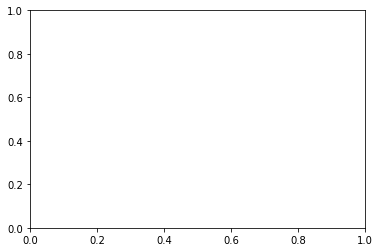

In [172]:
ut = u_abbot.values
vt = v_abbot.values

# Interpolate u to the rho-grid
w_bdry_u = ut[:,:,0]
middle_u = 0.5*(ut[:,:,0:-1] + ut[:,:,1:])
e_bdry_u = ut[:,:,-1]
u_rho = np.concatenate((w_bdry_u[:,:,None], middle_u, e_bdry_u[:,:,None]), axis=2)
# Interplate v to the rho-grid
s_bdry_v = vt[:,0,:]
middle_v = 0.5*(vt[:,0:-1,:] + vt[:,1:,:])
n_bdry_v = vt[:,-1,:]
v_rho = np.concatenate((s_bdry_v[:,None,:], middle_v, n_bdry_v[:,None,:]), axis=1)

In [181]:
umask.shape

(2650, 3149)

In [179]:
dV = grd.dV.where(mask).dropna('eta_rho','all').dropna('xi_rho','all')
weights = dV/dV.sum()
weights.shape

(31, 123, 52)

In [50]:
for key,data in log_progress(shelves.items(),every=2):  
    #print('.')
    shelves[key]['temp_front'] = temp.where(data['mask_front']).mean(temp.dims).load()
    #print('.')
    shelves[key]['salt_front'] = salt.where(data['mask_front']).mean(salt.dims).load()
    #print('.')
    shelves[key]['velo_front'] = calc_velo(u,v,data['mask_front']).load()

In [71]:
test={}
for sn,sv in shelves.items():
    test[sn] = {k: v.values for k, v in sv.items() if k in ['temp_front','salt_front','velo_front']}

In [73]:
pd.DataFrame.from_dict(test,orient='index')

,temp_front,salt_front,velo_front
Abbot,-0.9074458,34.10001,0.079010576
Abbot 1,-1.3072728,33.923138,0.029010393
Abbot 2,-1.2870028,33.906067,0.0150408605
Abbot 3,-1.2473053,33.95844,0.052129213
Abbot 4,-1.2266529,33.963863,0.06424116
Abbot 5,-1.2295661,33.935814,0.04123218
Abbot 6,-1.1768923,33.950066,0.040602468
Ainsworth,-1.6158998,34.228935,0.022373952
Alison,-0.9967669,34.11275,0.013682545
Amery,-1.7179648,34.248142,0.030292792


ValueError: DataFrame constructor not properly called!

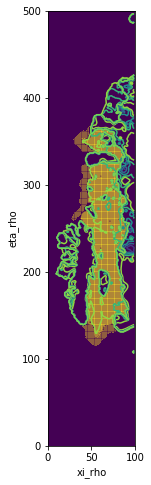

In [34]:
plt.close()
fig,ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(mask_fr[1000:1500,500:600])
grd2.zice[1000:1500,500:600].plot.contour(ax=ax)
grd2.mask_rho[1000:1500,500:600].plot.contour(ax=ax)
ax.pcolormesh(mask[1000:1500,500:600],alpha=0.2)
ax.set_aspect('equal')
plt.show()